# Activate GPU and install fast.ai

# IMPORT REQUIRED MODELS

In [1]:
import fastai
from fastai import *
from fastai.text import * 
from fastai.text.models import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
import re 
from bs4 import BeautifulSoup

from nltk.stem.snowball import SnowballStemmer

# Prepare data

In [2]:
# Not excluding stopwords as it performs better
stops={}

In [3]:
#PREPROCEESING THE TEXT

def text_preprocessing(text, language, minWordSize):
    
    # remove html
    text_html = BeautifulSoup(text,"html.parser" ).get_text()
    
    # remove non-letters
    text_non_letters = re.sub("[^a-zA-Z']", " ", text_html) 
        
    # convert to lower-case
    text_lower = text_non_letters.lower()
    
    # remove stop words
    text_no_stop_words = ' '
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '  
    
    # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '
         
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '
    return text_no_short_words

In [47]:
#load and prepare old data
df_reviews = pd.read_csv('Input_data/Old_data_reviews.csv',sep=',',quotechar='"' ) #contains the reviews from Facebook and Tripadvisor
df_cat_labels = pd.read_csv('Input_data/Old_data_categorisation_labels.csv',sep=',',quotechar='"') # contains the classlabels of the reviews
df_merged_data = pd.merge(df_cat_labels,df_reviews,how='left',left_on='review_id',right_on='id')

# Drop unnecessary columns
df_merged_data = df_merged_data.drop(['labeler_id', 'post_type', 'datetime_posted','likes', 'traveler_type',
                    'rating_food','rating_service', 'rating_environment', 'rating_value',
                     'reviewer_id','source_subject_id','id_x','review_id','id_y','source'],axis=1)

#select english reviews
def change_ratings(x):
    if x in [0, 1,2]:
        return -1
    elif x == 3:
        return 0
    else:
        return 1
olddata =  df_merged_data.loc[df_merged_data['language'] == 'en']
olddata['sentiment'] = olddata['rating'].apply(change_ratings)
reviews_old = olddata['text'].values
sentiment_old=olddata['sentiment'].values


In [12]:
#load and prepare new data
newdata=pd.read_csv('Input_data/New_data.csv')
# olddata = pd.read_csv("Input_data/Old_data_reviews.csv")
# newdata = pd.concat([newdata, olddata])
reviews_new= newdata['Text'].values
sentiment_new = newdata['Sentiment'].values

#Split category column 
newdata['category']=newdata['Categories'].apply(lambda x:x.split(';'))

def category_includer(data,string):    
    for i in range(len(data)):
        data.loc[i,string]=0
        column=list(data.loc[i,'category'])
        if string in column:
            data.loc[i,string]=1
    return data

newdata=category_includer(newdata,'experience')
newdata=category_includer(newdata,'service')
newdata=category_includer(newdata,'consistency')
newdata=category_includer(newdata,'value')
newdata=category_includer(newdata,'food')
newdata=category_includer(newdata,'convenience')

#dropping the two columns and filter only English
newdata=newdata.drop(['Categories','category'],axis=1)
newdata=newdata[newdata['Language']=="eng"]

In [15]:
# Preprocess

#reviews and sentiment as values
reviews_new= newdata['Text'].values
sentiment_new = newdata['Sentiment'].values

reviews = list(reviews_new) + list(reviews_old)
sentiment = list(sentiment_new) + list(sentiment_old)
#test train split
reviews_train, reviews_test, sentiment_train, sentiment_test = train_test_split(reviews, sentiment, test_size=0.2,random_state=0,stratify=sentiment)

#bag of words
language = 'english'
minWordLength = 2 # shorter words will be removed

for i in range(len(reviews_train)):
    reviews_train[i] = text_preprocessing(reviews_train[i], language, minWordLength)
for i in range(len(reviews_test)):
    reviews_test[i] = text_preprocessing(reviews_test[i], language, minWordLength)
        


/Users/arul/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://www.valkyriestudios.be" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


# Create and train models

In [16]:
# Create language databunch
data_lm = TextLMDataBunch.from_df(train_df = pd.DataFrame({'text': reviews_train, 'labels': sentiment_train}), 
                                  valid_df = pd.DataFrame({'text': reviews_test, 'labels':sentiment_test}), 
                                  path = "",
                                 text_cols=0,
                                 label_cols=1)

# Create classifier databunch
data_clas = TextClasDataBunch.from_df(path = "", 
                                      train_df = pd.DataFrame({'text': reviews_train, 'labels': sentiment_train}),
                                      valid_df = pd.DataFrame({'text': reviews_test, 'labels': sentiment_test}), 
                                      vocab=data_lm.train_ds.vocab, bs=16,
                                     text_cols=0,
                                 label_cols=1)

In [17]:
# Load pre-trained (Wikipedia) model, which predicts the next word
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.3);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


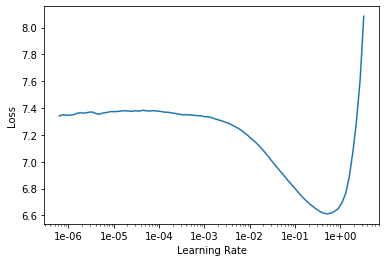

In [18]:
# Run learning rate finder and plot to find good learning rates
learn.lr_find()
learn.recorder.plot()

In [19]:
#Save in case want to restart from here
learn.save('fit_head')

In [0]:
#Load in case want to restart from here
learn.load('fit_head');

In [20]:
# Train the language model, which predicts the next word in a review, on the reviews data bunch.
# Train last layers for 1 epoch
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.937283,4.680444,0.200412,18:30


In [21]:
#Unfreeze and train for another epoch
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.526453,4.472011,0.223457,20:33
1,4.278420,4.257001,0.245134,19:31
2,3.991890,4.117462,0.261359,19:15
3,3.756675,4.049525,0.269965,18:55
4,3.637866,4.039631,0.271969,19:14


In [22]:
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')

In [0]:
learn.load('fine_tuned');
learn.load_encoder('fine_tuned_enc');

In [23]:
# Test what words it would predict
TEXT = "I had a"
N_WORDS = 40
N_SENTENCES = 2

In [24]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I had a amaz meal at claridg in brussel which certain count on the rank of best restaur in london we will definit be back xxbos brasseri anniversari which was fantast so from start to finish we had great meal and share the
I had a amaz meal here and was not disappoint the chef was absolut blown away by the delici beef and the servic thank you xxbos we want to tri the tast menu for the soup and everi cours was delici with tasti


In [25]:
# Create classification model
learn = text_classifier_learner(data_clas, AWD_LSTM,drop_mult=0.2);

In [42]:
#Visualize the data
data_clas.show_batch()

ValueError: Value must be a nonnegative integer or None

In [27]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12050 items)
x: TextList
xxbos the dinner was veri nice off to tri them all xxunk ron,xxbos come to daniel was great way to celebr my birthday the servic was amaz the dinner was delici the dessert was out of this world would definit recommend this restaur but bring your wallet as with most notori chef daniel charg for what you came for,xxbos big space multi level cafe restaur we had the sunday breakfast lot of fruit juic pastri scrambl egg and extra coffe all for less than you would pay in hotel profession waiter,xxbos dinner here is an amaz dine experi the food is exquisit prepar and delici and the servic is impecc we both had the degust menu and we delight with everi food cours there are alway waiter to serv you food and describ each dish to you they also provid cover stool for ladi handbag the best part of the meal as it was unexpect for us was the fresh bake warm butteri and sweet madelein utter amaz the onli critic was that the

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


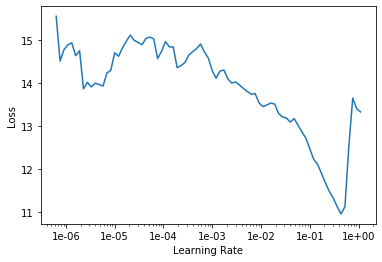

In [29]:
learn.recorder.plot()

In [30]:
# Train the classification model for one cycle
# learn.fit_one_cycle(1, 1e-1) #test
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,time
0,2.692591,1.754592,17:44


In [31]:
learn.save('first')

In [0]:
learn.load('first');

In [32]:
# train again after unfreezing part
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,2.361434,1.541512,19:32


In [33]:
learn.save('second')

In [0]:
learn.load('second');

In [34]:
# train again after unfreezing further
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,1.926550,1.289218,26:14


In [35]:
learn.save('third')

In [0]:
learn.load('third');

In [36]:
# train again after unfreezing full
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,1.814087,1.228117,35:48
1,1.762110,1.161799,33:35
2,1.402475,0.966216,40:41
3,1.567373,0.946640,34:40
4,1.490822,0.986350,37:50


In [37]:
#Get results for example
learn.predict("A Solid Good cafe - I say this, because i felt as though the service and the price could have been better. I almost felt ignored initially, but maybe that was because they were understaffed. I feel as though, with the price their, the service should have a bit more of a wow factor. But because of the high price and OK service I am rating a little lower. Coffee is great and the food is good too. I would go back!")

(FloatItem [0.726943], tensor([0.7269]), tensor([0.7269]))

# Get accuracy and export

In [38]:
# Get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis = 1)
accuracy_matrix=pd.crosstab(predictions, targets)


In [39]:
# print confusion matrix
accuracy_matrix2=accuracy_matrix.copy()
accuracy_matrix2=accuracy_matrix2.rename(columns={0:-1,1:0,2:1})
accuracy_matrix2=accuracy_matrix2.rename(index={0: -1, 1:0, 2: 1})
accuracy_matrix2.T

row_0,-1
col_0,
-1.0,177
-1.0,60
0.0,779
1.0,47
3.0,129
4.0,429
5.0,1392


In [0]:
# Calculate different accuracy measures
precision_minus_1=accuracy_matrix[0][0]/accuracy_matrix.sum(1)[0]
precision_0 = accuracy_matrix[1][1]/accuracy_matrix.sum(1)[1]
precision_1 = accuracy_matrix[2][2]/accuracy_matrix.sum(1)[2]
precision=[precision_minus_1,precision_0,precision_1]
recall_minus_1 = accuracy_matrix[0][0]/accuracy_matrix.sum(0)[0]
recall_0 = accuracy_matrix[1][1]/accuracy_matrix.sum(0)[1]
recall_1 = accuracy_matrix[2][2]/accuracy_matrix.sum(0)[2]
recall=[recall_minus_1,recall_0,recall_1]
weighted_precision = (precision[0]*accuracy_matrix.sum(0)[0]+ precision[1]*accuracy_matrix.sum(0)[1]+ precision[2]*accuracy_matrix.sum(0)[2])/sum(accuracy_matrix.sum(0))
weighted_recall = (recall[0]*accuracy_matrix.sum(1)[0]+ recall[1]*accuracy_matrix.sum(1)[1]+ recall[2]*accuracy_matrix.sum(1)[2])/sum(accuracy_matrix.sum(1))

In [61]:
print('The weighted average precision is %.2f'%(weighted_precision))


The weighted average precision is 0.90


In [ ]:
# Export and download the file
learn.export('train_new_test_new_sentiment_bestmodel_ulmfit.pkl');
files.download('train_new_test_new_sentiment_bestmodel_ulmfit.pkl');

In [0]:
#upload the file to google drive then get the path of the file
path='/content'

In [0]:
#load the file 
l = load_learner(path, 'export.pkl')

In [69]:
# predicted probability of -1, 0, 1
l.predict("High quality food,well served,few dishes,clean,young,very friendly. Has a part of a large pavement's corner with wood tables and benches.Wonderful place to have breakfast.")

(Category 1, tensor(2), tensor([0.1001, 0.0798, 0.8200]))